## Setup

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 8.0), 'image.interpolation': 'nearest', 'image.cmap': 'gray'})

def visualize_tensor_grid(tensor_data):
    flat_data = tensor_data.view(tensor_data.shape[0], -1).detach().cpu().numpy()
    grid_dim = int(np.ceil(np.sqrt(flat_data.shape[0])))
    img_dim = int(np.ceil(np.sqrt(flat_data.shape[1])))

    fig = plt.figure(figsize=(grid_dim, grid_dim))
    gs = gridspec.GridSpec(grid_dim, grid_dim)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img_data in enumerate(flat_data):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img_data.reshape([img_dim, img_dim]))
    plt.show()

tanh_transform = lambda x: 2 * x - 1.0
inverse_tanh = lambda x: (x + 1.0) / 2.0

def rel_error(a, b):
    return np.max(np.abs(a - b) / (np.maximum(1e-8, np.abs(a) + np.abs(b))))

def count_params(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

checkpoint_arrays = {}

for key, val in np.load('/content/drive/MyDrive/VAE-GAN/gan-checks-tf.npz').items():
    checkpoint_arrays[key] = torch.tensor(val)

## Dataset

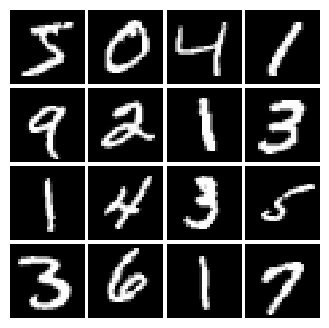

In [19]:
transform_chain = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST('./data', train=True, download=True, transform=transform_chain)
data_stream = DataLoader(mnist_data, batch_size=16, shuffle=False)

data_iter = iter(data_stream)
batch_imgs, batch_targets = next(data_iter)
visualize_tensor_grid(batch_imgs)

LATENT_DIM = 10
SAMPLE_SIZE = 10000

## Random Noise

Make sure noise is the correct shape and type:

In [21]:
def generate_random_input(size, dimensions):
   return torch.rand(size, dimensions) * 2 - 1

def validate_noise_function():
   n_samples = 3
   feature_dim = 4
   noise_tensor = generate_random_input(n_samples, feature_dim)
   assert list(noise_tensor.shape) == [n_samples, feature_dim]
   assert isinstance(noise_tensor, torch.Tensor)
   first_sample = generate_random_input(n_samples, feature_dim)
   second_sample = generate_random_input(n_samples, feature_dim)
   assert not np.array_equal(first_sample.numpy(), second_sample.numpy())
   assert np.all(first_sample.numpy() >= -1.0) and np.all(first_sample.numpy() <= 1.0)
   print("All tests passed!")

validate_noise_function()

All tests passed!


## Discriminator

In [22]:
import torch.nn as nn

class Discriminator(nn.Module):
   def __init__(self, feature_size=784):
       super(Discriminator, self).__init__()
       self.layer1 = nn.Linear(feature_size, 256)
       self.layer2 = nn.Linear(256, 256)
       self.output_layer = nn.Linear(256, 1)

   def forward(self, inputs):
       hidden = F.leaky_relu(self.layer1(inputs), 0.2)
       hidden = F.leaky_relu(self.layer2(hidden), 0.2)
       return self.output_layer(hidden)

Test to make sure the number of parameters in the discriminator is correct:

In [23]:
def validate_discriminator_params(expected_params=267009):
   net = Discriminator()
   actual_params = count_params(net)
   if actual_params != expected_params:
       print('Parameter count mismatch: got {0}, expected {1}'.format(actual_params, expected_params))
   else:
       print('Parameter count verified successfully.')

validate_discriminator_params()

Parameter count verified successfully.


## Generator

In [24]:
import torch.nn as nn

class Generator(nn.Module):
   def __init__(self, input_dim=LATENT_DIM):
       super(Generator, self).__init__()
       self.layer1 = nn.Linear(input_dim, 1024)
       self.layer2 = nn.Linear(1024, 1024)
       self.output_layer = nn.Linear(1024, 784)

   def forward(self, noise):
       hidden = F.relu(self.layer1(noise))
       hidden = F.relu(self.layer2(hidden))
       return torch.tanh(self.output_layer(hidden))

Test to make sure the number of parameters in the generator is correct:

In [ ]:
def validate_generator_params(expected_params=1858320):
   net = Generator(4)
   actual_params = count_params(net)
   if actual_params != expected_params:
       print('Parameter count mismatch: got {0}, expected {1}'.format(actual_params, expected_params))
   else:
       print('Parameter count verified successfully.')

validate_generator_params()

Correct number of parameters in generator.


# GAN Loss

In [25]:
import torch
import torch.nn as nn


def compute_discriminator_loss(real_scores, fake_scores):
   real_loss = torch.nn.functional.binary_cross_entropy_with_logits(
       real_scores, torch.ones_like(real_scores))
   fake_loss = torch.nn.functional.binary_cross_entropy_with_logits(
       fake_scores, torch.zeros_like(fake_scores))
   total_loss = real_loss + fake_loss
   return total_loss

def compute_generator_loss(fake_scores):
   loss = torch.nn.functional.binary_cross_entropy_with_logits(
       fake_scores, torch.ones_like(fake_scores))
   return loss

Test GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-8.

In [26]:
def validate_discriminator_loss(real_logits, fake_logits, expected_loss):
   calculated_loss = compute_discriminator_loss(real_logits, fake_logits)
   print("Maximum error in d_loss: %g"%rel_error(expected_loss.numpy(), calculated_loss.numpy()))

validate_discriminator_loss(checkpoint_arrays['logits_real'], checkpoint_arrays['logits_fake'],
                          checkpoint_arrays['d_loss_true'])

Maximum error in d_loss: 0


In [27]:
def validate_generator_loss(fake_logits, expected_loss):
   calculated_loss = compute_generator_loss(fake_logits)
   print("Maximum error in g_loss: %g"%rel_error(expected_loss.numpy(), calculated_loss.numpy()))

validate_generator_loss(checkpoint_arrays['logits_fake'], checkpoint_arrays['g_loss_true'])

Maximum error in g_loss: 7.19722e-17


## Optimizing loss

In [28]:
import torch.optim as optim

def create_optimizers(discriminator, generator, lr=1e-3, beta1=0.5):
   disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
   gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
   return disc_optimizer, gen_optimizer

## Training a GAN

In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_gan_model(disc_net, gen_net, disc_opt, gen_opt, disc_loss_fn, gen_loss_fn,
                  display_freq=20, log_freq=20, batch_sz=128, epochs=10,
                  latent_dim=LATENT_DIM):
   disc_net = disc_net.to(device)
   gen_net = gen_net.to(device)
   data_transform = transforms.Compose([transforms.ToTensor()])
   data_loader = DataLoader(
       datasets.MNIST(root='./data', train=True, download=True, transform=data_transform),
       batch_size=batch_sz, shuffle=True
   )

   step_counter = 0
   for ep in range(epochs):
       for batch_x, _ in data_loader:
           real_batch = batch_x.view(batch_x.size(0), -1).to(device)

           disc_opt.zero_grad()
           real_scores = disc_net(tanh_transform(real_batch))

           noise_vec = generate_random_input(batch_sz, latent_dim).to(device)
           generated_imgs = gen_net(noise_vec)
           fake_scores = disc_net(generated_imgs)

           disc_error = disc_loss_fn(real_scores, fake_scores)
           disc_error.backward()
           disc_opt.step()

           gen_opt.zero_grad()
           noise_vec = generate_random_input(batch_sz, latent_dim).to(device)
           generated_imgs = gen_net(noise_vec)
           gen_fake_scores = disc_net(generated_imgs)

           gen_error = gen_loss_fn(gen_fake_scores)
           gen_error.backward()
           gen_opt.step()

           if step_counter % display_freq == 0:
               print(f'Epoch: {ep}, Iter: {step_counter}, D: {disc_error.item():.4f}, G: {gen_error.item():.4f}')
               output_imgs = generated_imgs[:16].detach().cpu()
               visualize_tensor_grid(output_imgs)
               plt.show()

           step_counter += 1

   final_noise = generate_random_input(batch_sz, latent_dim).to(device)
   final_samples = gen_net(final_noise).detach().cpu()
   print('Final images')
   visualize_tensor_grid(final_samples[:16])
   plt.show()

In [30]:
disc_model = Discriminator()

gen_model = Generator()

disc_optimizer, gen_optimizer = create_optimizers(disc_model, gen_model)

train_gan_model(disc_model, gen_model, disc_optimizer, gen_optimizer, compute_discriminator_loss, compute_generator_loss)

Output hidden; open in https://colab.research.google.com to view.

## Least Squares GAN

In [32]:
import torch

def lsgan_disc_loss(real_outputs, fake_outputs):
   real_error = torch.mean((real_outputs - 1)**2)
   fake_error = torch.mean(fake_outputs**2)
   total_error = 0.5 * (real_error + fake_error)
   return total_error

def lsgan_gen_loss(fake_outputs):
   error = 0.5 * torch.mean((fake_outputs - 1)**2)
   return error

In [33]:
def validate_lsgan_loss(real_scores, fake_scores, expected_d_loss, expected_g_loss):
   calculated_d_loss = lsgan_disc_loss(real_scores, fake_scores)
   calculated_g_loss = lsgan_gen_loss(fake_scores)
   print("Maximum error in d_loss: %g"%rel_error(expected_d_loss.numpy(), calculated_d_loss.numpy()))
   print("Maximum error in g_loss: %g"%rel_error(expected_g_loss.numpy(), calculated_g_loss.numpy()))

validate_lsgan_loss(checkpoint_arrays['logits_real'], checkpoint_arrays['logits_fake'],
                  checkpoint_arrays['d_loss_lsgan_true'], checkpoint_arrays['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps to minimize the LSGAN loss:

In [34]:
disc_model = Discriminator()

gen_model = Generator()

disc_optimizer, gen_optimizer = create_optimizers(disc_model, gen_model)

train_gan_model(disc_model, gen_model, disc_optimizer, gen_optimizer, lsgan_disc_loss, lsgan_gen_loss)

Output hidden; open in https://colab.research.google.com to view.

## Deep Convolutional GANs

Architecture:
* Conv2D: 32 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
   def __init__(self):
       super(Discriminator, self).__init__()

       self.layer1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=0, bias=True)
       self.activation1 = nn.LeakyReLU(0.01)
       self.downsample1 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.layer2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0, bias=True)
       self.activation2 = nn.LeakyReLU(0.01)
       self.downsample2 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.reshape = nn.Flatten()
       self.dense1 = nn.Linear(4 * 4 * 64, 4 * 4 * 64, bias=True)
       self.activation3 = nn.LeakyReLU(0.01)
       self.output = nn.Linear(4 * 4 * 64, 1, bias=True)

   def forward(self, inputs):
       if inputs.dim() == 2:
           inputs = inputs.view(inputs.size(0), 1, 28, 28)
       features = self.activation1(self.layer1(inputs))
       features = self.downsample1(features)
       features = self.activation2(self.layer2(features))
       features = self.downsample2(features)
       features = self.reshape(features)
       features = self.activation3(self.dense1(features))
       result = self.output(features)
       return result

network = Discriminator()
validate_discriminator_params(1102721)

Parameter count verified successfully.


## Generator

Architecture:
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128
* `ReLU`
* BatchNorm
* Resize into Image Tensor of size 7, 7, 128
* Conv2D^T (transpose): 64 filters of 4x4, stride 2
* `ReLU`
* BatchNorm
* Conv2d^T (transpose): 1 filter of 4x4, stride 2
* `TanH`

In [37]:
import torch
import torch.nn as nn

class Generator(nn.Module):
   def __init__(self, input_dim=LATENT_DIM):
       super(Generator, self).__init__()

       self.dense1 = nn.Linear(input_dim, 1024, bias=True)
       self.norm1 = nn.BatchNorm1d(1024)
       self.dense2 = nn.Linear(1024, 7 * 7 * 128, bias=True)
       self.norm2 = nn.BatchNorm1d(7 * 7 * 128)
       self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=True)
       self.norm3 = nn.BatchNorm2d(64)
       self.upconv2 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=True)
       self.activation = nn.ReLU()
       self.output_activation = nn.Tanh()

   def forward(self, noise):
       features = self.activation(self.norm1(self.dense1(noise)))
       features = self.activation(self.norm2(self.dense2(features)))
       features = features.view(-1, 128, 7, 7)
       features = self.activation(self.norm3(self.upconv1(features)))
       result = self.output_activation(self.upconv2(features))
       return result

## Train and evaluate a DCGAN

In [38]:
disc_model = Discriminator()

gen_model = Generator()

disc_optimizer, gen_optimizer = create_optimizers(disc_model, gen_model)

train_gan_model(disc_model, gen_model, disc_optimizer, gen_optimizer, lsgan_disc_loss, lsgan_gen_loss, epochs=5)

Output hidden; open in https://colab.research.google.com to view.

### Inception score

In [39]:
batch_sz = 128
n_classes = 10
training_epochs = 20

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_chain)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_chain)

train_stream = DataLoader(mnist_train, batch_size=batch_sz, shuffle=True)
test_stream = DataLoader(mnist_test, batch_size=batch_sz)

print(f'{len(mnist_train)} train samples')
print(f'{len(mnist_test)} test samples')

class NeuralClassifier(nn.Module):
   def __init__(self):
       super(NeuralClassifier, self).__init__()
       self.layer1 = nn.Linear(784, 512)
       self.layer2 = nn.Linear(512, 512)
       self.output_layer = nn.Linear(512, n_classes)

   def forward(self, inputs):
       inputs = torch.flatten(inputs, start_dim=1)
       inputs = F.relu(self.layer1(inputs))
       inputs = F.dropout(inputs, 0.2)
       inputs = F.relu(self.layer2(inputs))
       inputs = F.dropout(inputs, 0.2)
       inputs = self.output_layer(inputs)
       return inputs

   def prob(self, inputs):
       inputs = self.forward(inputs)
       probabilities = F.softmax(inputs, dim=-1)
       return probabilities

classifier = NeuralClassifier().to(device)
solver = optim.RMSprop(classifier.parameters(), lr=0.001, alpha=0.9)
loss_fn = nn.CrossEntropyLoss()

for ep in range(training_epochs):
   classifier.train()
   for data_x, data_y in train_stream:
       data_x = data_x.to(device)
       data_y = data_y.to(device)
       solver.zero_grad()
       predictions = classifier(data_x)
       error = loss_fn(predictions, data_y)
       error.backward()
       solver.step()
   print(f'Epoch {ep+1}/{training_epochs}, Loss: {error.item():.4f}')

classifier.eval()
accurate = 0
total_samples = 0
with torch.no_grad():
   for data_x, data_y in test_stream:
       data_x = data_x.to(device)
       data_y = data_y.to(device)
       predictions = classifier(data_x)
       predicted_labels = torch.argmax(predictions, dim=1)
       total_samples += data_y.size(0)
       accurate += (predicted_labels == data_y).sum().item()

print('Test accuracy:', accurate / total_samples)

60000 train samples
10000 test samples
Epoch 1/20, Loss: 0.1123
Epoch 2/20, Loss: 0.1083
Epoch 3/20, Loss: 0.0464
Epoch 4/20, Loss: 0.0764
Epoch 5/20, Loss: 0.0572
Epoch 6/20, Loss: 0.0390
Epoch 7/20, Loss: 0.0306
Epoch 8/20, Loss: 0.0065
Epoch 9/20, Loss: 0.0366
Epoch 10/20, Loss: 0.1009
Epoch 11/20, Loss: 0.0547
Epoch 12/20, Loss: 0.0114
Epoch 13/20, Loss: 0.0021
Epoch 14/20, Loss: 0.0017
Epoch 15/20, Loss: 0.0050
Epoch 16/20, Loss: 0.0118
Epoch 17/20, Loss: 0.0026
Epoch 18/20, Loss: 0.0452
Epoch 19/20, Loss: 0.0875
Epoch 20/20, Loss: 0.0410
Test accuracy: 0.979


## Verify the trained classifier on the generated samples

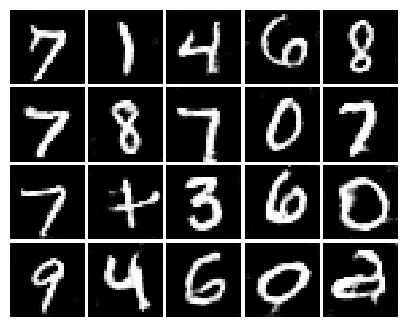

In [40]:
with torch.no_grad():
   noise_input = generate_random_input(SAMPLE_SIZE, LATENT_DIM).to(device)
   generated_output = gen_model(noise_input)
   processed_output = inverse_tanh(generated_output)
visualize_tensor_grid(processed_output[:20].cpu())
plt.show()

## Implement the inception score

In [41]:
with torch.no_grad():
   is_score = None

   sample_imgs = processed_output.view(-1, 1, 28, 28).to(device)
   class_probs = classifier.prob(sample_imgs)

   marginal_dist = torch.mean(class_probs, dim=0)

   divergence = class_probs * (torch.log(class_probs + 1e-16) - torch.log(marginal_dist.unsqueeze(0) + 1e-16))
   divergence = torch.sum(divergence, dim=1)

   is_score = torch.exp(torch.mean(divergence)).item()

print(f'Inception score: {is_score:.4f}')

Inception score: 9.4011


## Histogram of predicted labels